### Effective Radius Comparison

Compare forward model with different wavelengths and reffs.

In [1]:
#imports

import at3d
import numpy as np
import xarray as xr
from collections import OrderedDict
import pylab as py
import copy
np.random.seed(1)

cloud_scatterer = at3d.util.load_from_csv('/Users/khargenr/AT3D/at3d/data/synthetic_cloud_fields/jpl_les/rico122x106x39.txt',
                                           density='lwc',origin=(0.0,0.0))

#load atmosphere
atmosphere = xr.open_dataset('/Users/khargenr/AT3D/at3d/data/ancillary/AFGL_summer_mid_lat.nc')
#subset the atmosphere, choose only the bottom four km.
reduced_atmosphere = atmosphere.sel({'z': atmosphere.coords['z'].data[atmosphere.coords['z'].data <= 4.0]})
#merge the atmosphere and cloud z coordinates
merged_z_coordinate = at3d.grid.combine_z_coordinates([reduced_atmosphere,cloud_scatterer])

# define the property grid - which is equivalent to the base RTE grid
rte_grid = at3d.grid.make_grid(cloud_scatterer.x.diff('x')[0],cloud_scatterer.x.data.size,
                          cloud_scatterer.y.diff('y')[0],cloud_scatterer.y.data.size,
                          cloud_scatterer.z.data)

#finish defining microphysics because we can.

cloud_scatterer_on_rte_grid = at3d.grid.resample_onto_grid(rte_grid, cloud_scatterer)

#We choose a gamma size distribution and therefore need to define a 'veff' variable.
size_distribution_function = at3d.size_distribution.gamma

cloud_scatterer_on_rte_grid['reff'] = (cloud_scatterer_on_rte_grid.reff.dims,
                                       np.full_like(cloud_scatterer_on_rte_grid.reff.data, fill_value=10))

cloud_scatterer_on_rte_grid['veff'] = (cloud_scatterer_on_rte_grid.reff.dims,
                                       np.full_like(cloud_scatterer_on_rte_grid.reff.data, fill_value=0.1))


Save mie tables

In [2]:
# for wavelength in wavelengths:
#     mie_mono_tables[wavelength].to_netcdf(path='../mie_tables/' + str(wavelength) + '_mie_table.nc')

### USE DIFFERENT R_e and LWC MULTIPLICITY

In [3]:

wavelength = .660#.865, 1.240, 1.640, 2.130] 
sensor_zenith_list = [60.0, 0.0, 60.0]
sensor_azimuth_list = [65.0, 0.0, 65+180.0]
epsilons = [.01]
multiplicities = [0, 1, 2, 3]
sensor_dicts3D = []
for zenith,azimuth in zip(sensor_zenith_list,sensor_azimuth_list):
        sensor_dicts2D = []
        for epsilon in epsilons:
                sensor_dicts = []
                for multiplicity in multiplicities:
                        sensor_dict = at3d.containers.SensorsDict()
                        sensor_dict.add_sensor('MSPI', 
                                        at3d.sensor.orthographic_projection(wavelength, cloud_scatterer,0.02,0.02, azimuth, zenith,
                                        altitude='TOA', stokes='I'))
                        sensor_dicts.append(sensor_dict)
                sensor_dicts2D.append(sensor_dicts)
        sensor_dicts3D.append(sensor_dicts2D)        

In [4]:
mie_mono_tables = OrderedDict()
mie_mono_tables[wavelength] = at3d.mie.get_mono_table(
    'Water',(wavelength,wavelength),
    max_integration_radius=65.0,
    minimum_effective_radius=0.1,
    relative_dir='../mie_tables',
    verbose=False
)

In [5]:
optical_property_generator = at3d.medium.OpticalPropertyGenerator(
    'cloud', 
    mie_mono_tables,
    size_distribution_function,
    reff=np.linspace(5.0,45,40),
    veff=np.linspace(0.03,0.37,18),
)
optical_properties = optical_property_generator(cloud_scatterer_on_rte_grid)

In [6]:
# one function to generate rayleigh scattering.
rayleigh_scattering = at3d.rayleigh.to_grid([wavelength],atmosphere,rte_grid)

In [7]:

medium = {
            'cloud': optical_properties[wavelength],
            'rayleigh':rayleigh_scattering[wavelength]
            }
mediums2D = []
for epsilon in epsilons:
    mediums = []
    for multiplicity in multiplicities:
        temp_medium = copy.deepcopy(medium)
        temp_medium["cloud"].ssalb.data = medium["cloud"].ssalb.data - (multiplicity * epsilon)
        mediums.append(temp_medium)
    mediums2D.append(mediums)

solver_dicts2D = []
for mediums in mediums2D:
# note we could set solver dependent surfaces / sources / numerical_config here
# just as we have got solver dependent optical properties.
    solver_dicts = []
    for new_medium in mediums:
        solvers_dict = at3d.containers.SolversDict()
        config = at3d.configuration.get_config()
        solvers_dict.add_solver(
            wavelength,
            at3d.solver.RTE(
                numerical_params=config,
                surface=at3d.surface.lambertian(0.0),
                source=at3d.source.solar(wavelength, 0.5,0.0),
                medium=new_medium,
                num_stokes=1#sensor_dict.get_minimum_stokes()[wavelength],
            )                   
    )
        solver_dicts.append(solvers_dict)
    solver_dicts2D.append(solver_dicts)

adapt_grid_factor reduced to  1.823170395087474


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '37'. Max cell optical depth: '2.529850959777832'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


adapt_grid_factor reduced to  1.823170395087474


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '44'. Max cell optical depth: '2.5498359203338623'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


adapt_grid_factor reduced to  1.823170395087474


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '47'. Max cell optical depth: '2.5698208808898926'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


adapt_grid_factor reduced to  1.823170395087474


/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '52'. Max cell optical depth: '2.589806079864502'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


In [8]:
for mediums in mediums2D:
    for medium in mediums:
        print(medium["cloud"].ssalb.data[0][0][0])

0.9999973177909851
0.9899973177909851
0.9799973177909851
0.9699973177909851


In [9]:
%%time
for sensor_dicts2D in sensor_dicts3D:
    for sensor_dicts, solver_dicts in zip(sensor_dicts2D, solver_dicts2D):
        for sensor_dict, solver_dict in zip(sensor_dicts, solver_dicts):
        # solve the 4 RTEs in parallel AND get the measurements.
            sensor_dict.get_measurements(solver_dict, n_jobs=4, verbose=True)

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.810  0.438E+00   504348    16.92  0.066   [Radiance 0.660 micron]
     2  -1.583  0.478E+00   504348    16.92  0.066   [Radiance 0.660 micron]
     3  -1.856  0.478E+00   504366    16.93  0.066   [Radiance 0.660 micron]
     4  -2.033  0.221E+00   506487    17.91  0.070   [Radiance 0.660 micron]
     5  -2.121  0.127E+00   515955    21.89  0.086   [Radiance 0.660 micron]
     6  -2.321  0.890E-01   528488    26.91  0.105   [Radiance 0.660 micron]
     7  -2.453  0.621E-01   552071    35.86  0.140   [Radiance 0.660 micron]
     8  -2.484  0.460E-01   586926    47.83  0.187   [Radiance 0.660 micron]
     9  -2.560  0.385E-01   617348    57.26  0.224   [Radiance 0.660 micron]
    10  -2.643  0.329E-01   650422    66.58  0.260   [Radiance 0.660 micron]
    11  -2.761  0.300E-01   673473    72.53  0.283   [Radiance 0.660 micron]
    12  -2.958  0.300E-01   674662    72.82  0.284   [Radiance 0.660 micron]
  

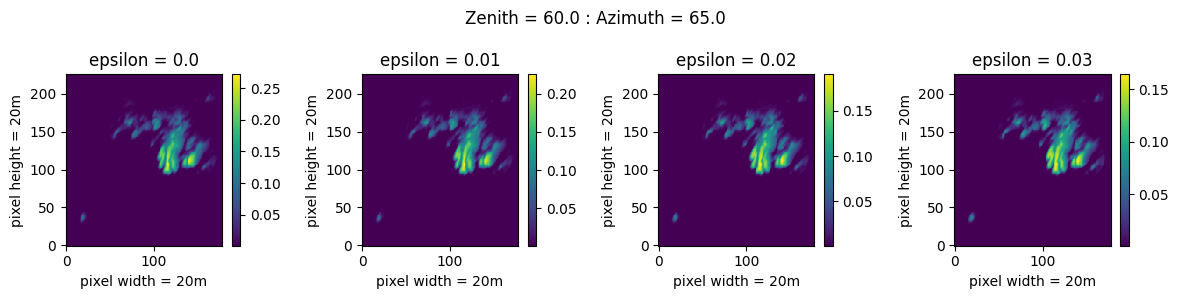

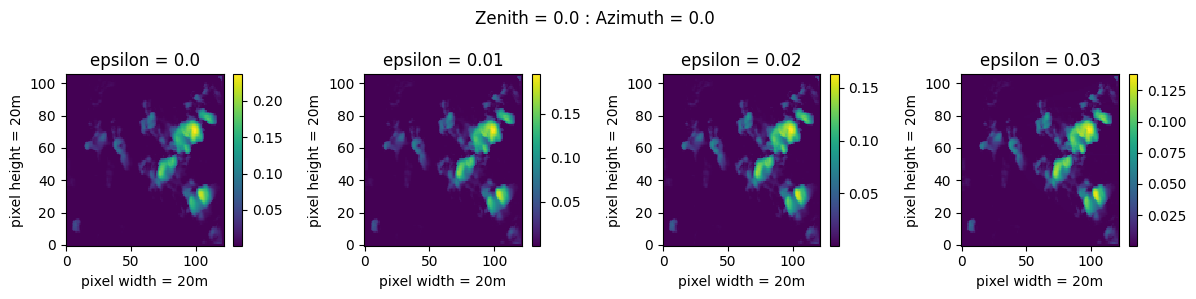

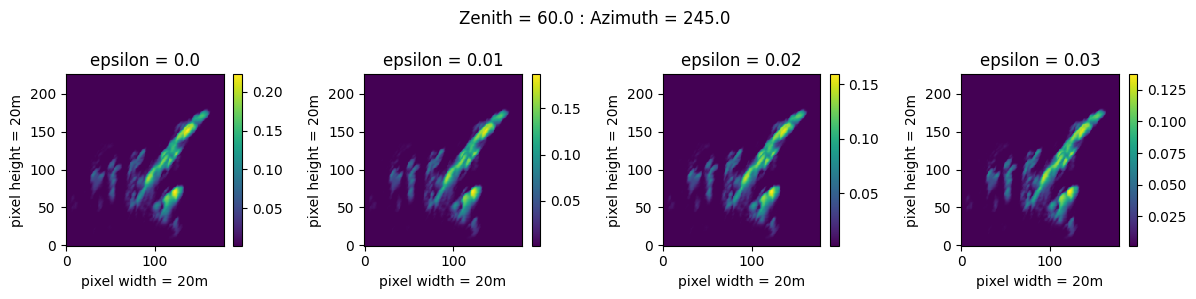

In [10]:
#plot
cmap = py.get_cmap('viridis')
cmap.set_under('white')
for i, sensor_dicts2D in enumerate(sensor_dicts3D): #sensor_dicts3D : angle x epsilon x multiplicity
    fig, axs = py.subplots(len(epsilons), len(multiplicities), figsize=(12, 3))  # Create a figure with subplots side by side
    py.suptitle("Zenith = " + str(sensor_zenith_list[i]) + " : Azimuth = " + str(sensor_azimuth_list[i]))
    for j, sensor_dicts in enumerate(sensor_dicts2D):
        for k, sensor_dict in enumerate(sensor_dicts):
            sensor_images = sensor_dict.get_images("MSPI")
            image = sensor_images[0]
            plot = image.I.T.plot(ax=axs[k])#, vmin=0, vmax=.18, cmap=cmap)
            colorbar = plot.colorbar
            colorbar.set_label("")
            axs[k].set_title("epsilon = " + str(epsilons[j] * multiplicities[k]))
            axs[k].set_xlabel("pixel width = 20m")
            axs[k].set_ylabel("pixel height = 20m")
    py.tight_layout()  # Adjust layout for better spacing
    py.show()

In [11]:
# #plot
# cmap = py.get_cmap('viridis')
# cmap.set_under('white')
# for i, sensor_dicts2D in enumerate(sensor_dicts3D): #sensor_dicts3D : angle x epsilon x multiplicity
#     fig, axs = py.subplots(len(epsilons), len(multiplicities), figsize=(12, 12))  # Create a figure with subplots side by side
#     py.suptitle("Zenith = " + str(sensor_zenith_list[i]) + " : Azimuth = " + str(sensor_azimuth_list[i]))
#     for j, sensor_dicts in enumerate(sensor_dicts2D):
#         for k, sensor_dict in enumerate(sensor_dicts):
#             if k == 0:
#                 base_image = sensor_dict.get_images("MSPI")[0]
#             else:
#                 image = sensor_dict.get_images("MSPI")[0]
#                 plot = ((image.I.T-base_image.I.T)/epsilons[j]).plot(ax=axs[j, k])#, vmin=0, vmax=.18, cmap=cmap)
#                 colorbar = plot.colorbar
#                 colorbar.set_label("")
#                 axs[j, k].set_title("First Derivative : epsilon = " + str(epsilons[j] * multiplicities[k]))
#                 axs[j, k].set_xlabel("pixel width = 20m")
#                 axs[j, k].set_ylabel("pixel height = 20m")
#     py.tight_layout()  # Adjust layout for better spacing
#     py.show()

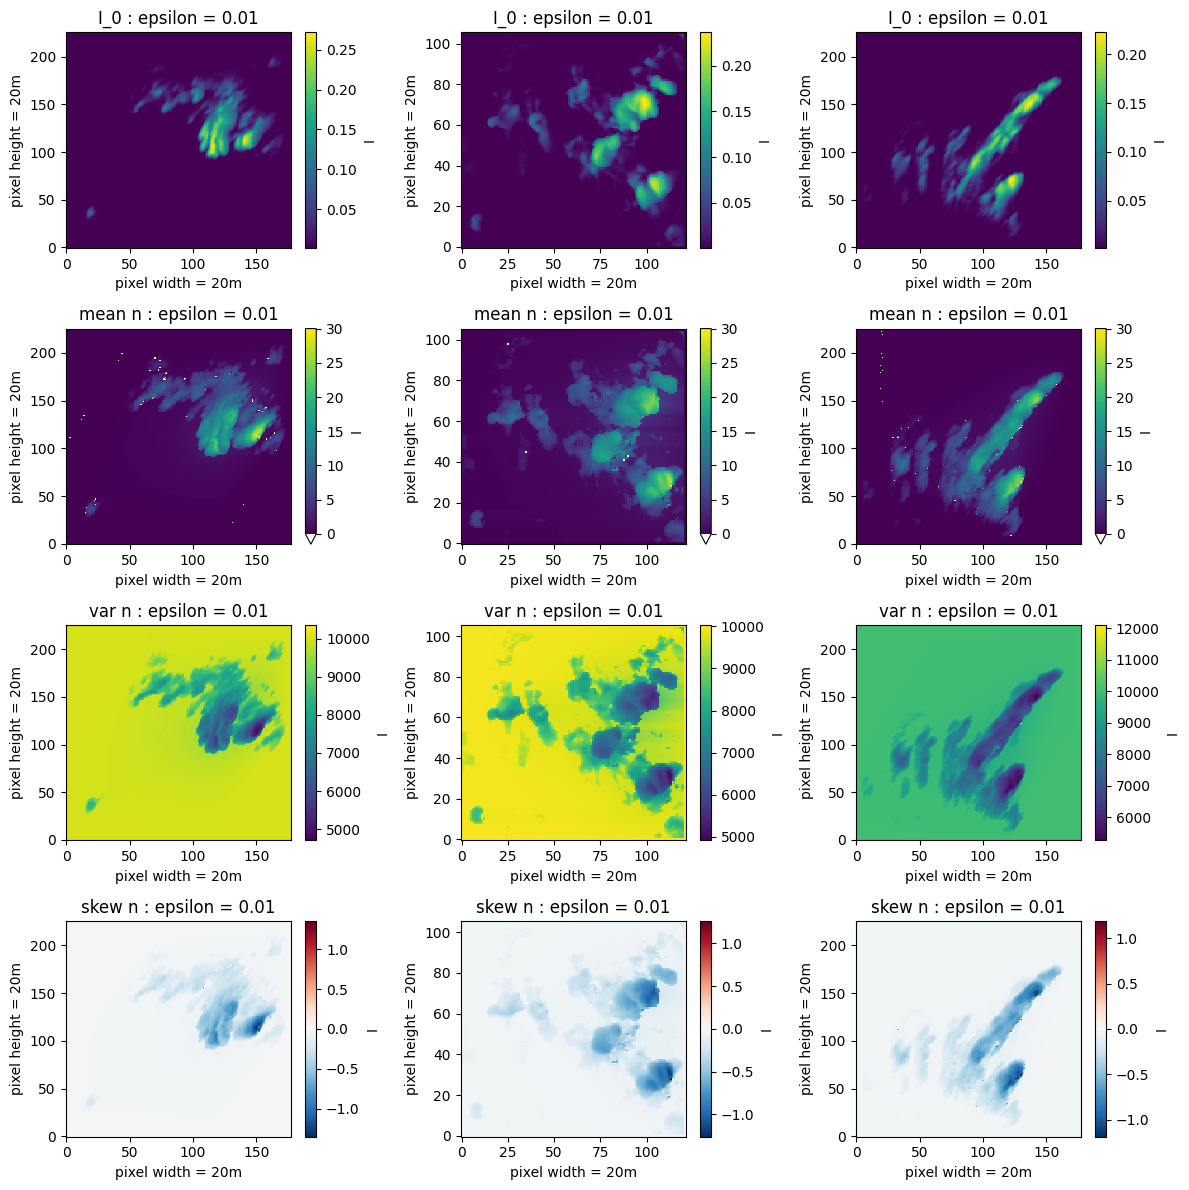

In [12]:
#plot
cmap = py.get_cmap('viridis')
cmap.set_under('white')
fig, axs = py.subplots(4, 3, figsize=(12, 12))  # Create a figure with subplots side by side
for i, sensor_dicts2D in enumerate(sensor_dicts3D): #sensor_dicts3D : angle x epsilon x multiplicity
    j = 0
    sensor_dicts = sensor_dicts2D[0]
    I_0 = sensor_dicts[0].get_images("MSPI")[0].I.T
    I_1 = sensor_dicts[1].get_images("MSPI")[0].I.T
    I_2 = sensor_dicts[2].get_images("MSPI")[0].I.T
    I_3 = sensor_dicts[3].get_images("MSPI")[0].I.T
    #I_prime = (I_1-I_0)/epsilons[j]
    # I2_prime = (I_0+I_2 - 2*I_1) / ((epsilons[j]**2))
    I_prime = (-11*I_0 + 18*I_1 - 9*I_2 + 2*I_3)/(6*epsilons[j])
    I2_prime = (2*I_0 - 5*I_1 + 4*I_2 - 3*I_3)/(2*epsilons[j]**2)
    I3_prime = (I_3-3*I_2+3*I_1-I_0) /(6*epsilons[j]**3)
    n1 = - I_prime / I_0
    n2 = (I2_prime / I_0) + n1
    n3 = -(I3_prime / I_0) + 3*n2 - 2*n1
    var_n = np.abs(n2 - n1**2)
    std_n = np.sqrt(var_n)
    skew_n = (n3-3*n1*var_n-n1**3)/(var_n**(1.5))

    (I_0).plot(ax=axs[0, i])#, vmin=0, vmax=30, cmap=cmap)
    axs[0,i].set_title("I_0 : epsilon = " + str(epsilons[j]))
    axs[0,i].set_xlabel("pixel width = 20m")
    axs[0,i].set_ylabel("pixel height = 20m")

    (n1).plot(ax=axs[1, i], vmin=0, vmax=30, cmap=cmap)
    axs[1,i].set_title("mean n : epsilon = " + str(epsilons[j]))
    axs[1,i].set_xlabel("pixel width = 20m")
    axs[1,i].set_ylabel("pixel height = 20m")

    (var_n).plot(ax=axs[2, i])#, vmin=0, vmax=20000, cmap=cmap)
    axs[2,i].set_title("var n : epsilon = " + str(epsilons[j]))
    axs[2,i].set_xlabel("pixel width = 20m")
    axs[2,i].set_ylabel("pixel height = 20m")

    (skew_n).plot(ax=axs[3, i])#, vmin=-1.5, vmax=0, cmap=cmap)
    axs[3,i].set_title("skew n : epsilon = " + str(epsilons[j]))
    axs[3,i].set_xlabel("pixel width = 20m")
    axs[3,i].set_ylabel("pixel height = 20m")
py.tight_layout()  # Adjust layout for better spacing
py.show()

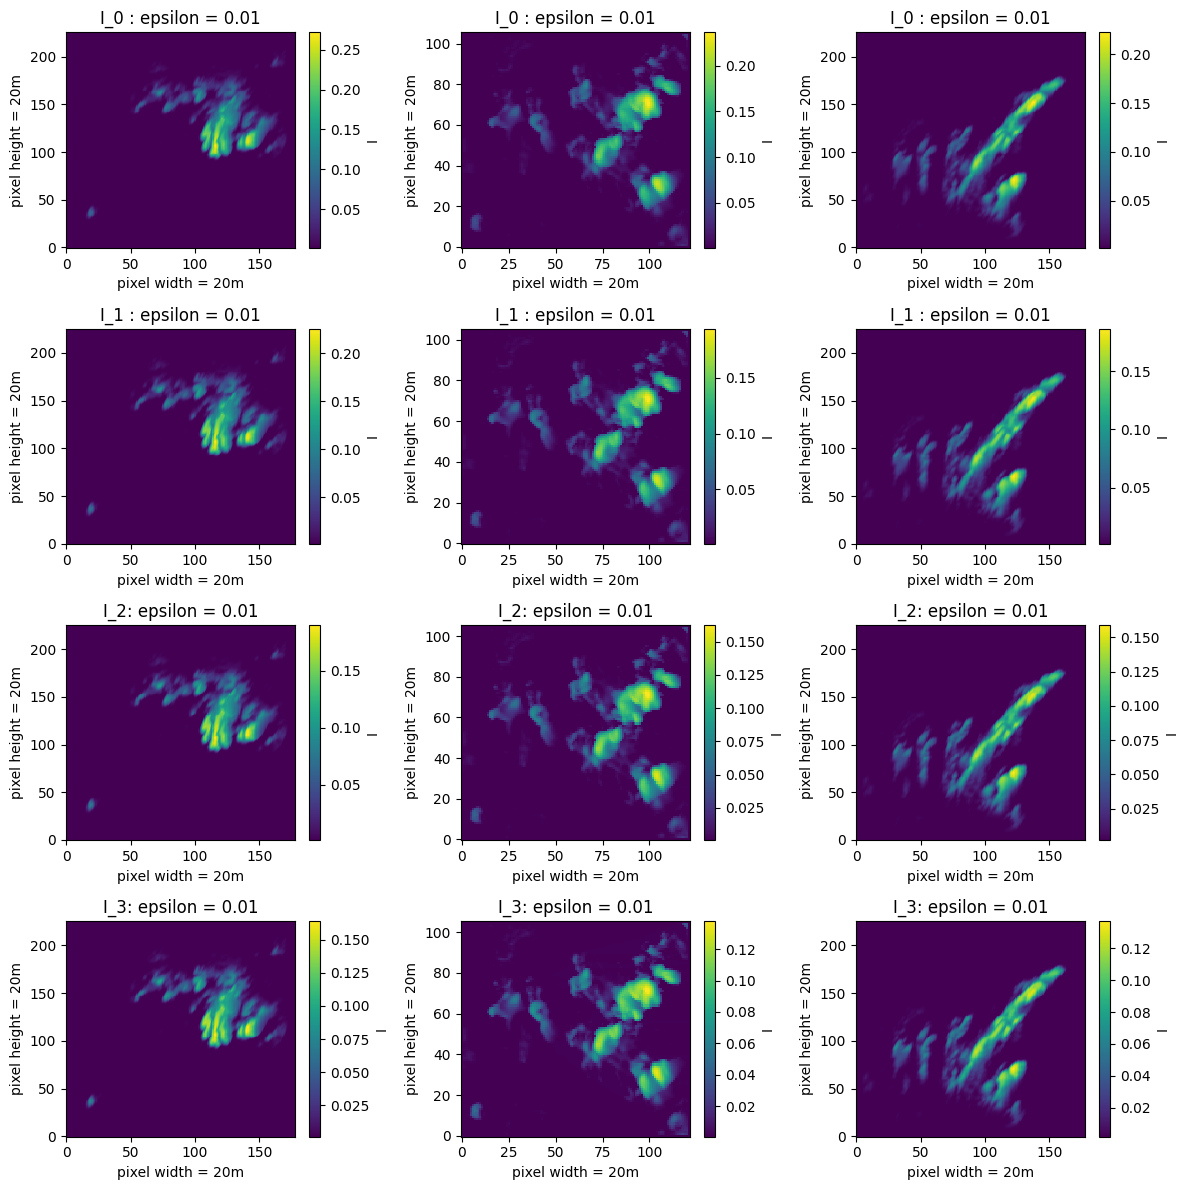

In [13]:
#plot
cmap = py.get_cmap('viridis')
cmap.set_under('white')
fig, axs = py.subplots(4, 3, figsize=(12, 12))  # Create a figure with subplots side by side
for i, sensor_dicts2D in enumerate(sensor_dicts3D): #sensor_dicts3D : angle x epsilon x multiplicity
    j = 0
    sensor_dicts = sensor_dicts2D[0]
    I_0 = sensor_dicts[0].get_images("MSPI")[0].I.T
    I_1 = sensor_dicts[1].get_images("MSPI")[0].I.T
    I_2 = sensor_dicts[2].get_images("MSPI")[0].I.T
    I_3 = sensor_dicts[3].get_images("MSPI")[0].I.T
    #I_prime = (I_1-I_0)/epsilons[j]
    # I2_prime = (I_0+I_2 - 2*I_1) / ((epsilons[j]**2))
    I_prime = (-11*I_0 + 18*I_1 - 9*I_2 + 2*I_3)/(6*epsilons[j])
    I2_prime = (2*I_0 - 5*I_1 + 4*I_2 - 3*I_3)/(2*epsilons[j]**2)
    I3_prime = (I_3-3*I_2+3*I_1-I_0) / (6*epsilons[j]**3)
    n1 = - I_prime / I_0
    n2 = (I2_prime / I_0) + n1
    n3 = -(I3_prime / I_0) + 3*n2 - 2*n1
    var_n = np.abs(n2 - n1**2)
    std_n = np.sqrt(var_n)
    skew_n = (n3-3*n1*var_n-n1**3)/(var_n**(1.5))

    I_0.plot(ax=axs[0, i])#, vmin=0, vmax=30, cmap=cmap)
    axs[0,i].set_title("I_0 : epsilon = " + str(epsilons[j]))
    axs[0,i].set_xlabel("pixel width = 20m")
    axs[0,i].set_ylabel("pixel height = 20m")

    I_1.plot(ax=axs[1, i])#, vmin=0, vmax=30, cmap=cmap)
    axs[1,i].set_title("I_1 : epsilon = " + str(epsilons[j]))
    axs[1,i].set_xlabel("pixel width = 20m")
    axs[1,i].set_ylabel("pixel height = 20m")

    I_2.plot(ax=axs[2, i])#, vmin=0, vmax=20000, cmap=cmap)
    axs[2,i].set_title("I_2: epsilon = " + str(epsilons[j]))
    axs[2,i].set_xlabel("pixel width = 20m")
    axs[2,i].set_ylabel("pixel height = 20m")

    I_3.plot(ax=axs[3, i])#, vmin=-1.5, vmax=0, cmap=cmap)
    axs[3,i].set_title("I_3: epsilon = " + str(epsilons[j]))
    axs[3,i].set_xlabel("pixel width = 20m")
    axs[3,i].set_ylabel("pixel height = 20m")
py.tight_layout()  # Adjust layout for better spacing
py.show()

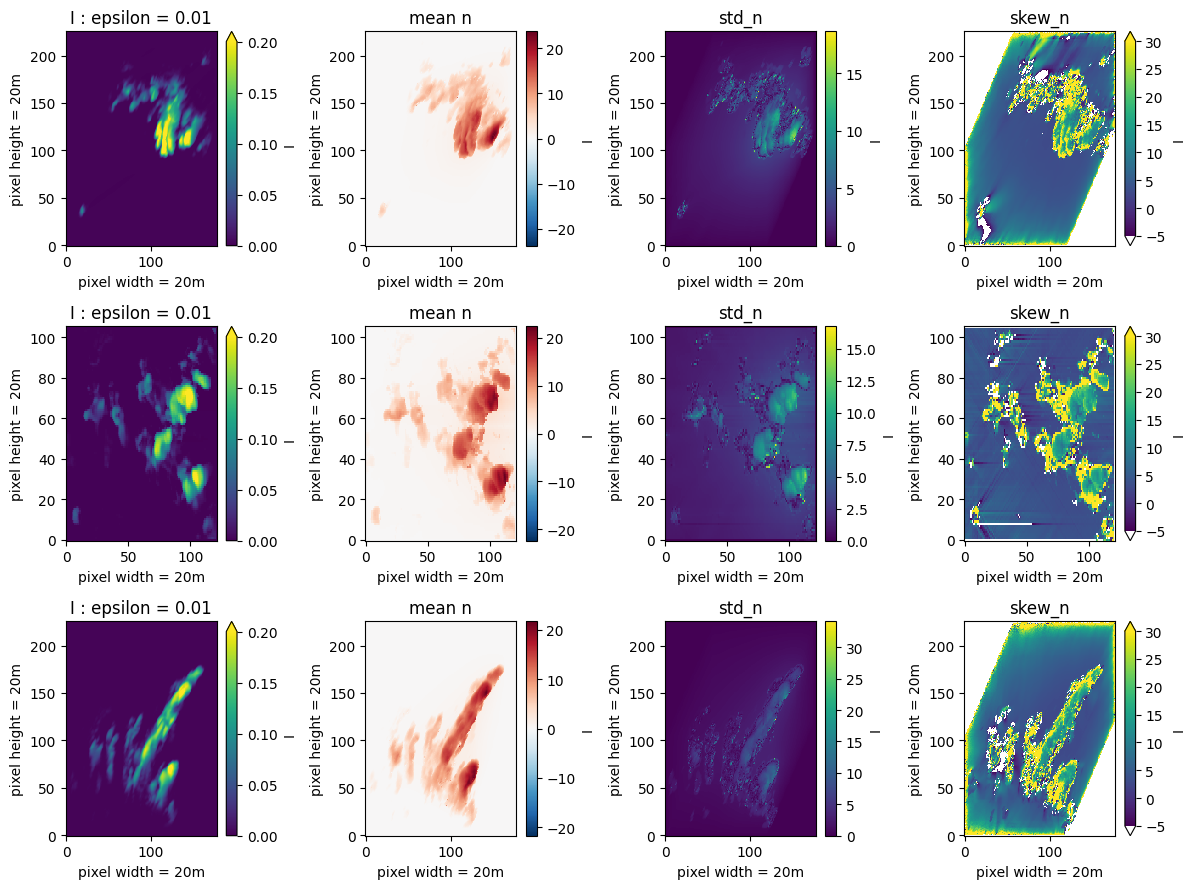

In [16]:
import matplotlib.patches as patches

start_row, end_row = [20, 20, 20-9, 20-10], [25, 25, 25-9, 25-10]  # Rows from 1 to 2 (inclusive)
start_col, end_col = [6, 6+8, 6, 6+20], [9, 9+8, 9, 9+20]  # Columns from 2 to 3 (inclusive)
# plot
cmap = py.get_cmap('viridis')
cmap.set_under('white')
fig, axs = py.subplots(3, 4, figsize=(12, 9))  # Create a figure with subplots side by side

j=0
for i in range(3):
    sensor_dicts2D = sensor_dicts3D[i]
    sensor_dicts = sensor_dicts2D[0]

    I_full = sensor_dicts[0].get_images("MSPI")[0].I.T.copy(deep=True)
    I_0_full = I_full
    I_1_full = sensor_dicts[1].get_images("MSPI")[0].I.T
    I_2_full = sensor_dicts[2].get_images("MSPI")[0].I.T
    I_3_full = sensor_dicts[3].get_images("MSPI")[0].I.T

    I_prime_full = (I_1_full-I_0_full)/epsilons[j]
    I2_prime_full = (I_0_full+I_2_full - 2*I_1_full) / (2*(epsilons[j]**2))
    # I_prime_full = (-11*I_0_full + 18*I_1_full - 9*I_2_full + 2*I_3_full)/(6*epsilons[j])
    # I2_prime_full = (2*I_0_full - 5*I_1_full + 4*I_2_full - 3*I_3_full)/(2*epsilons[j]**2)
    I3_prime_full = -(I_3_full-3*I_2_full+3*I_1_full-I_0_full) / (6*epsilons[j]**3)
    n1_full = - I_prime_full / I_0_full
    n2_full = (I2_prime_full / I_0_full) + n1_full
    n3_full = -(I3_prime_full / I_0_full) + 3*n2_full - 2*n1_full
    var_n_full = abs(n2_full - n1_full**2)
    std_n_full = np.sqrt(var_n_full)
    skew_n_full = -(n3_full-3*n1_full*var_n_full-n1_full**3)/(var_n_full**(1.5))

    # axs[1,i].plot([I_0[1][2],I_1[1][2], I_2[1][2], I_3[1][2]]/I_0[1][2].data)
    # axs[1,i].set_title("I vs e_multiplicity")
    # axs[1,i].set_xlabel("e_multiplicity")
    # axs[1,i].set_ylabel("I")

    I_full.plot(ax=axs[i, 0], vmin=0, vmax=.20, cmap=cmap)
    axs[i,0].set_title("I : epsilon = " + str(epsilons[j]))
    axs[i, 0].set_xlabel("pixel width = 20m")
    axs[i, 0].set_ylabel("pixel height = 20m")

    n1_full.plot(ax=axs[i, 1])#, vmin=0, vmax=.20, cmap=cmap)
    axs[i, 1].set_title("mean n")
    axs[i, 1].set_xlabel("pixel width = 20m")
    axs[i, 1].set_ylabel("pixel height = 20m")

    std_n_full.plot(ax=axs[i, 2])#, vmin=0, vmax=.20, cmap=cmap)
    axs[i, 2].set_title("std_n")
    axs[i, 2].set_xlabel("pixel width = 20m")
    axs[i, 2].set_ylabel("pixel height = 20m")

    skew_n_full.plot(ax=axs[i, 3], vmin=-5, vmax=30, cmap=cmap)
    axs[i, 3].set_title("skew_n")
    axs[i, 3].set_xlabel("pixel width = 20m")
    axs[i, 3].set_ylabel("pixel height = 20m")

py.tight_layout()  # Adjust layout for better spacing
py.show()